In [ ]:
# !pip install bitsandbytes transformers accelerate

In [ ]:
import os
import sys

path = os.getcwd()
while True:
    if 'utils.py' in os.listdir(path):
        if path not in sys.path:
            sys.path.append(path)
        break
    new_path = os.path.dirname(path)
    if new_path == path:
        print("utils.py not found in any parent folder.")
        break
    path = new_path

import utils
import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch


c:\Users\User\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
utils.hf_login("HF_TOKEN")

In [5]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

In [6]:
model_id = 'google/gemma-2-9b-it'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quantization_config,
    attn_implementation="eager"
    )

# Add padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token

# Change the model to evaluation mode
model.eval()

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

2025-10-05 12:42:45.087226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759668165.294189      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759668165.350013      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors.index.json:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [7]:
scitail_test = pd.read_csv('/kaggle/input/scitail-test/scitail_test.csv')

In [8]:
scitail_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   premise                     2126 non-null   object
 1   hypothesis                  2126 non-null   object
 2   label                       2126 non-null   object
 3   hypothesis_graph_structure  2126 non-null   object
dtypes: object(4)
memory usage: 66.6+ KB


In [9]:
scitail_test.head()

,premise,hypothesis,label,hypothesis_graph_structure
0,Based on the list provided of the uses of subs...,"If a substance has a ph value greater than 7,t...",neutral,a substance<>has<>a ph value greater than 7
1,If one or two base pairs are change...,Invertebrates (and higher animals) can also be...,neutral,Invertebrates (and higher animals<>can be plac...
2,"At high temperatures, the solid dye converts i...",Gases and liquids become solids at low tempera...,neutral,Gases and liquids<>become<>solids
3,Chapter 11 Gas and Kinetic Theory .,The behavior of ideal gases is explained by ki...,neutral,The behavior of ideal gases<>is explained<>by ...
4,Both the continental crust and the oceanic cru...,Gabbro is a dark dense rock that can be found ...,neutral,Gabbro<>is<>a dark dense rock that can be foun...


In [ ]:
# Find the max_length for tokenization to avoid wasting computing.
utils.find_max_length(scitail_test, tokenizer=tokenizer, dataset_type='scitail')

In [ ]:
# Define dataset and create a dataloader.
dataset_test = utils.MyDataset(dataframe=scitail_test,
                               tokenizer=tokenizer,
                               dataset_type='scitail',
                               prompt_max_length=117,
                               label_max_length=3)

batch_size = 16 # Change batch size according to GPU
dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [ ]:
# Test
predictions, gold_labels, batch_probs = utils.test_run(model=model,
                                          dataloader=dataloader,
                                          tokenizer=tokenizer,
                                          dataset_type='scitail')

for i, pair in enumerate(zip(predictions, gold_labels)):
    print(pair, batch_probs[i])

neutral
neutral
neutral
entailment


In [7]:
# Create checkpoint
checkpoint_path = utils.create_checkpoint_path(model_id=model_id, name='scitail')

Saving to: c:\Users\User\iCloudDrive\Desktop\DAMA_EAP\NLI_Study\Notebooks\Scitail_Notebooks\Scitail-gemma-2-9b-it-zero-shot\checkpoint_scitail_gemma_2_9b_it.pt


In [ ]:
from tqdm import tqdm

# Load checkpoint if it exists
predicted_labels, gold_labels, start_batch = utils.load_checkpoint(checkpoint_path=checkpoint_path)
labels = utils.get_labels('scitail')

# Loop over the batches
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader, desc="Evaluating", unit="batch")):

        # Continue from last checkpoint
        if i < start_batch:
            continue

        input_ids_batch = batch["input_ids"].to(model.device) # Move to GPU
        attention_mask_batch = batch["attention_mask"].to(model.device) # Move to GPU
        gold_labels_batch = batch["labels"] # Keep to CPU

        batch_probs = utils.get_model_probs(batch_input_ids=input_ids_batch,
                                      batch_attention_mask=attention_mask_batch,
                                      dataset_type='scitail',
                                      model=model,
                                      tokenizer=tokenizer)

        batch_pred_indices = torch.argmax(batch_probs, dim=1)
        batch_pred_labels = [labels[i] for i in batch_pred_indices]

        predicted_labels.extend(batch_pred_labels)
        gold_labels.extend(gold_labels_batch)

        # Save checkpoint
        if i % 50 == 0 or i == len(dataloader) - 1:
            torch.save({"predicted_labels": predicted_labels,
                        "gold_labels": gold_labels,
                        "batch_no": i+1}, checkpoint_path)

            print(f"Checkpoint saved: {i+1}, {checkpoint_path}")

Checkpoint found.
Accuracy: 0.5997.
 F1 Score: 0.5688.
 Matthew's Correlation Coefficient: 0.1421.
 Cohen's Kappa Score: 0.1410.


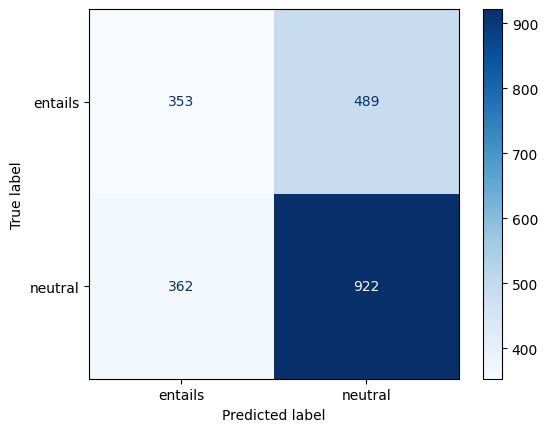

In [8]:
# Calculate metrics
predicted_labels, gold_labels, _ = utils.load_checkpoint(checkpoint_path)
utils.evaluate_metrics(predicted_labels=predicted_labels, gold_labels=gold_labels, dataset_type='scitail')